In [2]:
import os
import pandas as pd
import numpy as np
from rdkit import Chem, DataStructs
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import KBinsDiscretizer
from collections import defaultdict
from tqdm import tqdm
import random
from sklearn.model_selection import StratifiedKFold


In [3]:
N_REPEATS = 5
N_FOLDS = 5
RANDOM_SEEDS = [42, 43, 44, 45, 46]


SCRIPT_DIR = os.getcwd()
REPO_ROOT = os.path.abspath(os.path.join(SCRIPT_DIR, "..", ".."))
FOLD_OUTPUT_ROOT = os.path.join(REPO_ROOT, "data", "cv", "raw_h37rv_nr", "folds")

In [4]:
FOLD_OUTPUT_ROOT

'/home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds'

In [9]:
# Stratify continuous labels into bins
def stratify_labels(y, n_bins=10):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')
    y_binned = est.fit_transform(np.array(y).reshape(-1, 1)).astype(int).flatten()
    return y_binned

# Main function
def create_stratified_random_folds(df, dataset_name, output_root, n_repeats=N_REPEATS, n_folds=N_FOLDS, random_seeds=RANDOM_SEEDS):
    output_dir = os.path.join(output_root, dataset_name)
    os.makedirs(output_dir, exist_ok=True)

    smiles = df["smiles"].tolist()
    labels = df["label"].tolist()
    label_bins = stratify_labels(labels)

    for rep, seed in zip(range(n_repeats), random_seeds):
        print(f"\n🔁 Generating rep {rep} with seed {seed}")
        skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)

        for fold, (_, test_idx) in enumerate(skf.split(smiles, label_bins)):
            fold_df = df.iloc[test_idx].copy()
            fold_df["rep"] = rep
            fold_df["fold"] = fold

            out_path = os.path.join(output_dir, f"{dataset_name}_rep{rep}_fold{fold}.csv")
            fold_df.to_csv(out_path, index=False)
            print(f"✅ Saved: {out_path} ({len(fold_df)} molecules)")


In [ ]:
# === Run for all datasets ===
# Load datasets
df_raw = pd.read_csv(os.path.join(REPO_ROOT, "data", "cv", "raw_data_no_duplicates.csv"))
df_h37rv = pd.read_csv(os.path.join(REPO_ROOT, "data", "cv", "h37rv_filtered_data_no_duplicates.csv"))
df_nr = pd.read_csv(os.path.join(REPO_ROOT, "data", "cv", "nr_filtered_data_no_duplicates.csv"), low_memory=False)

df_raw["label"] = df_raw["mic_log"]
df_h37rv["label"] = df_h37rv["mic_log"]
df_nr["label"] = df_nr["mic_log"]

df_raw["smiles"] = df_raw["canonical_smiles"]
df_h37rv["smiles"] = df_h37rv["canonical_smiles"]
df_nr["smiles"] = df_nr["canonical_smiles"]


create_stratified_random_folds(df_raw, dataset_name="raw", output_root=FOLD_OUTPUT_ROOT)
create_stratified_random_folds(df_h37rv, dataset_name="h37rv", output_root=FOLD_OUTPUT_ROOT)
create_stratified_random_folds(df_nr, dataset_name="nr", output_root=FOLD_OUTPUT_ROOT)

print("\n✅ Done generating all folds.")


🔁 Generating rep 0 with seed 42
✅ Saved: /home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/raw/raw_rep0_fold0.csv (3756 molecules)
✅ Saved: /home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/raw/raw_rep0_fold1.csv (3756 molecules)
✅ Saved: /home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/raw/raw_rep0_fold2.csv (3756 molecules)
✅ Saved: /home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/raw/raw_rep0_fold3.csv (3756 molecules)
✅ Saved: /home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/raw/raw_rep0_fold4.csv (3756 molecules)

🔁 Generating rep 1 with seed 43
✅ Saved: /home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/raw/raw_rep1_fold0.csv (3756 molecules)
✅ Saved: /home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/raw/raw_rep1_fold1.csv (3756 molecules)
✅ Saved: /home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/raw/raw_rep1_fold2.csv (3756 molecules)
✅ Saved: /home/malves/predinhib_mtb/data/cv/raw_h37rv_nr/folds/raw/raw_rep1_fold3.csv (3756 molecules)
✅ Saved

In [11]:
from statistics import mean, stdev

def check_fold_balance(root_dir, dataset_name, n_repeats=5, n_folds=5):
    print(f"\n📦 Fold size summary for: {dataset_name}")
    for rep in range(n_repeats):
        sizes = []
        for fold in range(n_folds):
            path = os.path.join(root_dir, dataset_name, f"{dataset_name}_rep{rep}_fold{fold}.csv")
            df = pd.read_csv(path)
            sizes.append(len(df))
        print(f"🔁 Rep {rep}: min={min(sizes)}, max={max(sizes)}, mean={mean(sizes):.1f}, stdev={stdev(sizes):.1f}")

check_fold_balance(FOLD_OUTPUT_ROOT, "raw")
check_fold_balance(FOLD_OUTPUT_ROOT, "h37rv")
check_fold_balance(FOLD_OUTPUT_ROOT, "nr")


📦 Fold size summary for: raw
🔁 Rep 0: min=3756, max=3756, mean=3756.0, stdev=0.0
🔁 Rep 1: min=3756, max=3756, mean=3756.0, stdev=0.0
🔁 Rep 2: min=3756, max=3756, mean=3756.0, stdev=0.0
🔁 Rep 3: min=3756, max=3756, mean=3756.0, stdev=0.0
🔁 Rep 4: min=3756, max=3756, mean=3756.0, stdev=0.0

📦 Fold size summary for: h37rv
🔁 Rep 0: min=2837, max=2838, mean=2837.4, stdev=0.5
🔁 Rep 1: min=2837, max=2838, mean=2837.4, stdev=0.5
🔁 Rep 2: min=2837, max=2838, mean=2837.4, stdev=0.5
🔁 Rep 3: min=2837, max=2838, mean=2837.4, stdev=0.5
🔁 Rep 4: min=2837, max=2838, mean=2837.4, stdev=0.5

📦 Fold size summary for: nr
🔁 Rep 0: min=3680, max=3681, mean=3680.4, stdev=0.5
🔁 Rep 1: min=3680, max=3681, mean=3680.4, stdev=0.5
🔁 Rep 2: min=3680, max=3681, mean=3680.4, stdev=0.5
🔁 Rep 3: min=3680, max=3681, mean=3680.4, stdev=0.5
🔁 Rep 4: min=3680, max=3681, mean=3680.4, stdev=0.5



📂 Validating folds for: raw
✅ Loaded (93900, 64)


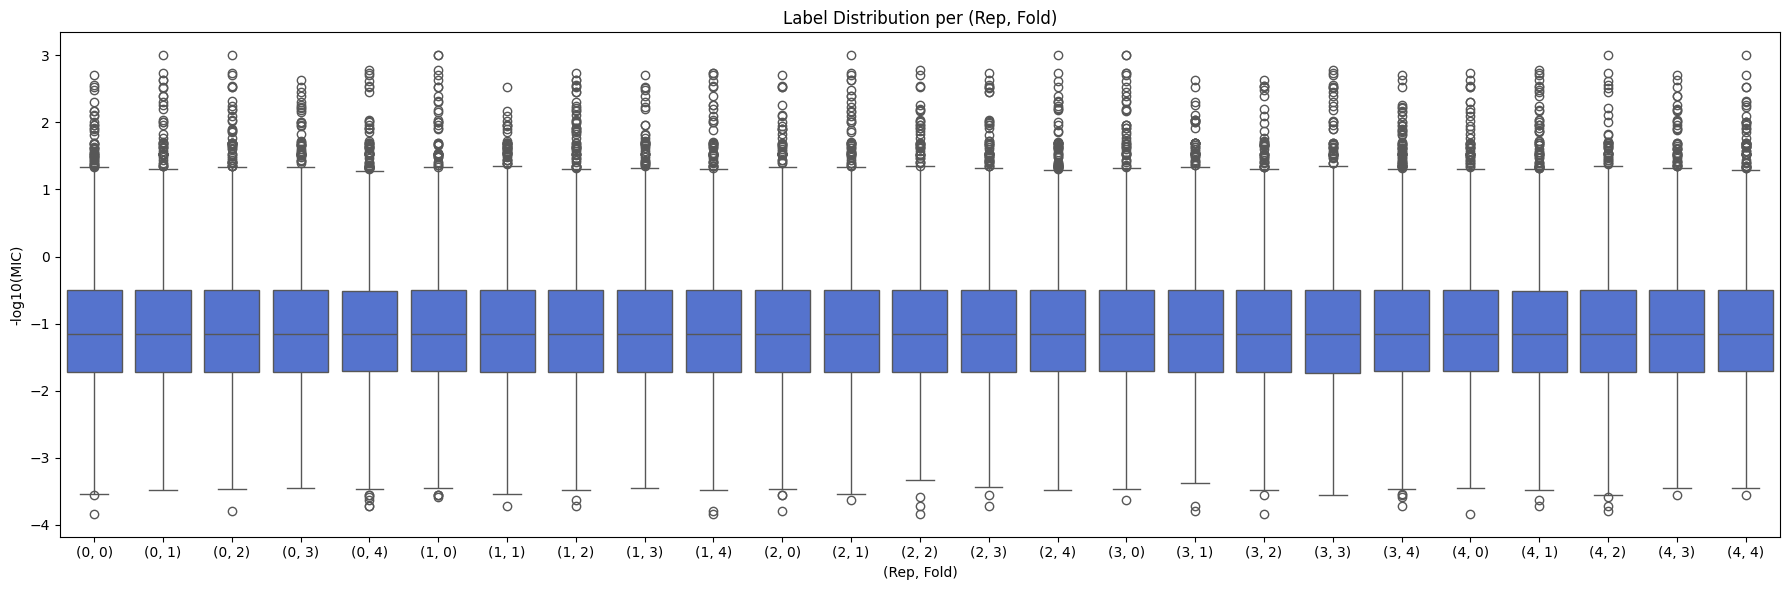


📂 Validating folds for: h37rv
✅ Loaded (70935, 64)


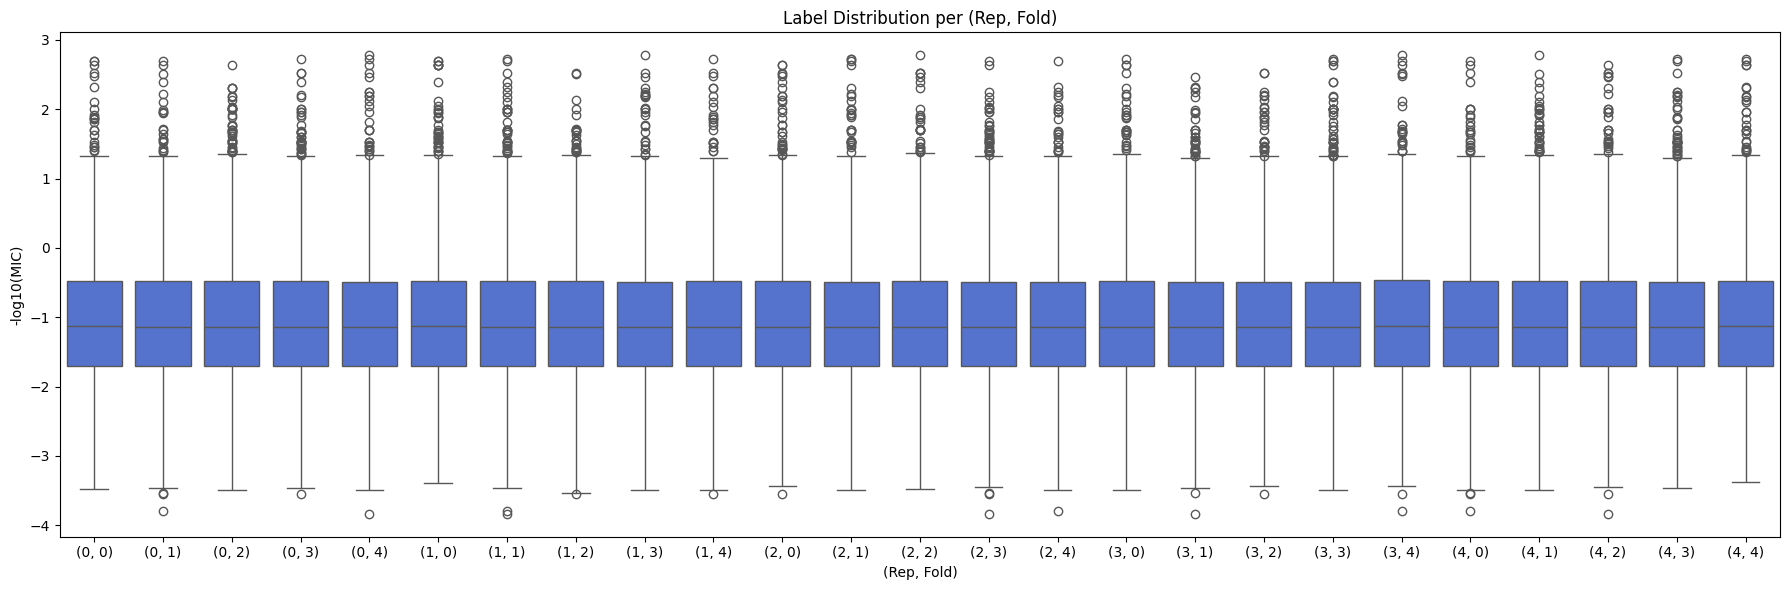


📂 Validating folds for: nr
✅ Loaded (92010, 64)


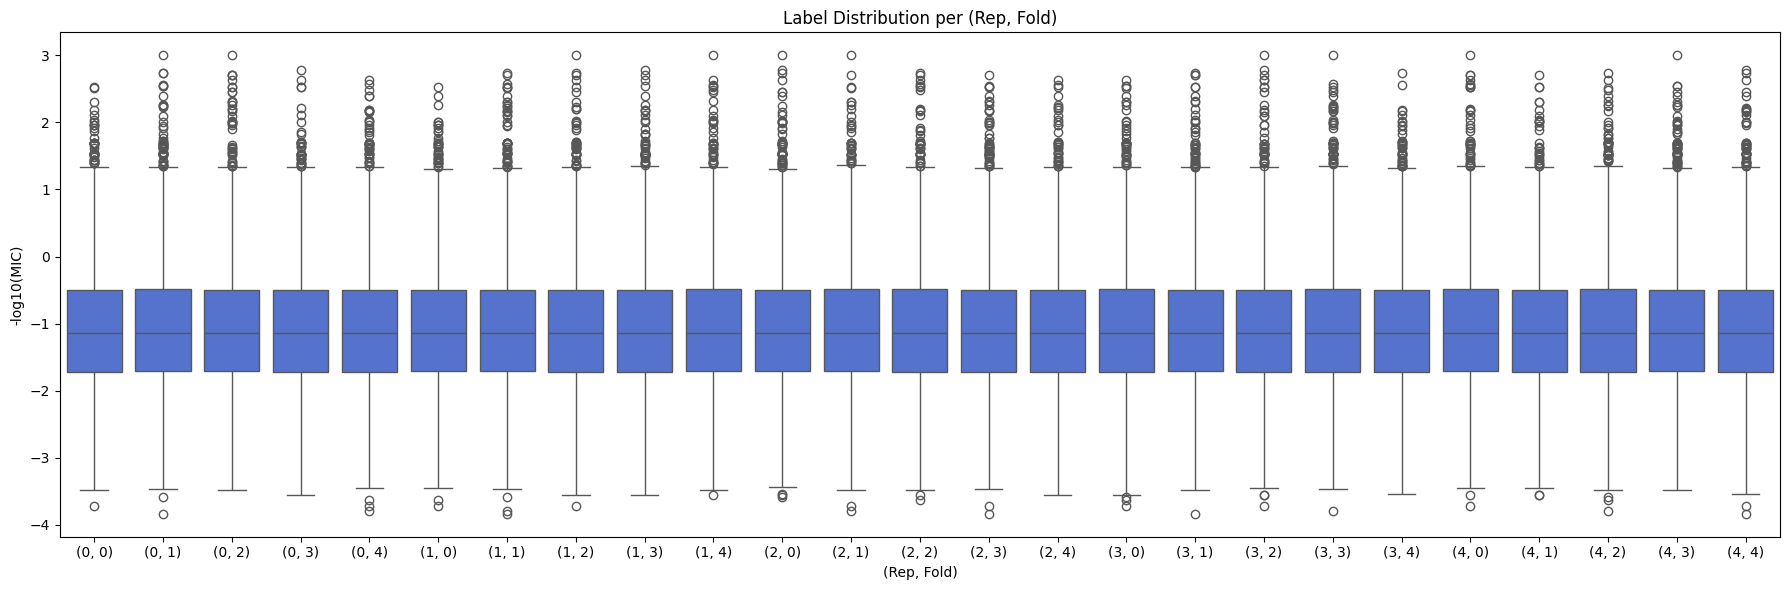

In [12]:
# === 📊 Fold Validation: Label Distribution ===
import matplotlib.pyplot as plt
import seaborn as sns

def validate_folds_label(dataset_name):
    print(f"\n📂 Validating folds for: {dataset_name}")
    fold_dir = os.path.join(FOLD_OUTPUT_ROOT, dataset_name)

    # Load all folds
    all_folds = []
    for rep in range(N_REPEATS):
        for fold in range(N_FOLDS):
            path = os.path.join(fold_dir, f"{dataset_name}_rep{rep}_fold{fold}.csv")
            df = pd.read_csv(path)
            df["rep"] = rep
            df["fold"] = fold
            all_folds.append(df)
    df_all = pd.concat(all_folds).reset_index(drop=True)
    print("✅ Loaded", df_all.shape)

    # Turn (rep, fold) into a nice string format like "(0, 0)"
    df_all["rep_fold"] = df_all.apply(lambda row: f"({row['rep']}, {row['fold']})", axis=1)

    # Plot
    plt.figure(figsize=(18, 6))
    sns.boxplot(x="rep_fold", y="label", data=df_all, color="royalblue")
    plt.xticks(rotation=0)  # horizontal
    plt.xlabel("(Rep, Fold)")
    plt.ylabel("-log10(MIC)")
    plt.title("Label Distribution per (Rep, Fold)")
    plt.tight_layout()
    plt.show()

# === Run validation for both datasets ===
validate_folds_label("raw")
validate_folds_label("h37rv")
validate_folds_label("nr")